# Regular Genomics Project **RNA Localisation**


---

**Problem definition**:

TODO


### **1.** Data Preparation

Firstly, we import several necessary packages and load in our data:

In [1]:
import pandas as pd
import numpy as np
from notes.utils import read_model_file
from models.utils import plot_line_graph, box_plot
from sklearn.model_selection import train_test_split
from keras.metrics import KLDivergence, CategoricalCrossentropy
from keras.callbacks import EarlyStopping
import datetime

In [2]:
# Initializing test/train split


colab = False  #### Set colab flag ####

if colab:
    np.random.seed(3)
    url = 'https://www.dropbox.com/s/hv4uau8q4wwg00k/final_data.csv?dl=1'
    data_org = pd.read_csv(url)
    test_data = data_org.sample(frac=0.1)
    train_data = data_org.drop(test_data.index)
else:
    np.random.seed(3)
    data_org = pd.read_csv('~/Downloads/final_data.csv')
    test_data = data_org.sample(frac=0.1)
    train_data = data_org.drop(test_data.index) # TODO: note: we also have to preprocess the test set similary
    # TODO: colab

data_org

,ERM,KDEL,LMA,MITO,NES,NIK,NLS,NUCP,OMM,gene_id,gene_biotype,seq,struct,m6A_5UTR,m6A_CDS,m6A_3UTR
0,57.045409,35.456782,22.008215,12.355106,22.789983,24.241731,16.970436,29.348389,54.916891,ENSG00000000003,protein_coding,ACCTTGTATTAGGTATTTATTTCCACAAAAGTTTGATGCTTACAAC...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,1
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.914814,0.244517,ENSG00000000005,protein_coding,TGTGCACAGAAGTTATATACATATATGGGTATATCTATGTAACAAA...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,0
2,17.449430,34.151539,29.338431,22.237585,24.682767,43.612551,38.683963,35.678476,25.348560,ENSG00000000419,protein_coding,TACTTTATGCAAAAAAAAATATACATTTATTTATAGGTCTCAATAC...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,0
3,3.830180,2.576734,5.737850,0.761343,2.786808,2.784356,3.382682,2.463676,2.819269,ENSG00000000457,protein_coding,TGACTTTCAAACCATTTTAATATTTCAAATATTCCAGAACAATCCC...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,9,5
4,13.132915,8.782925,10.061390,3.012459,8.821250,6.721117,10.827253,8.005113,6.849962,ENSG00000000460,protein_coding,AACCCGCTCGGGTCCCCTTCCACACTGTGGAAGCTTTGTTCTTTCG...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13805,0.000000,0.000000,0.506809,0.075893,0.050764,0.000000,0.056586,0.000000,0.000000,ENSG00000281883,protein_coding,GGGAAGAAAGGAGCCTGACTCTTATGATGGAATAACCACAAATCAG...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,2,1
13806,0.105452,0.087130,0.171187,0.016101,0.079057,0.669947,0.171672,0.000000,0.254546,ENSG00000282034,protein_coding,GTGTCGGACGGCATGACAGGCAGCAATCCTGTGTCCCCTGCCTCAT...,"[0.37599998712539673, 0.0, 0.07500000298023224...",0,66,4
13807,0.037093,0.444844,0.425368,0.254467,0.323794,1.803249,1.435483,0.249590,0.483645,ENSG00000282827,protein_coding,ATGGCGGGGACCTCCGCGCCAGGCAGCAAGAGGCGGAGCGAGCCCC...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,0
13808,0.000000,0.519421,2.119115,0.360450,0.887939,0.345021,1.274465,0.741954,0.460649,ENSG00000282936,protein_coding,CTACTGGAACGCCCCCCTCAATCTAGCCTCCCCCACATAACTCTCT...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,2


### **2** |  Initializations

We use as baseline model the [RNATracker](https://github.com/HarveyYan/RNATracker/blob/master/Models/cnn_bilstm_attention.py) model and a CNN model.


In [3]:
max_seq_len = train_data['seq'].apply(lambda x: len(x)).max()
# MODEL
#model_path = "model_architectures/"

# Path where to save viz
model_architecture_path = "model_architecture_viz/C.png"

params_dict = read_model_file('model_architectures/CNN_test.yaml', max_seq_len)
param_dataLoader_valid = params_dict['param_dataLoader_valid']
param_dataLoader_train = params_dict['param_dataLoader_train']
params_model = params_dict['params_model']
params_train = params_dict['params_train']

In [4]:
# training, only need for the model initialization to change in general
from models.functional_CNN import CNN
from keras.optimizers import Nadam
from keras.losses import KLDivergence
from keras import backend as K
import tensorflow_probability as tfp

def tf_pearson(y_true, y_pred):
    return tfp.stats.correlation(y_pred, y_true)[1]

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

# 80/20 split
train_split, valid_split = train_test_split(train_data, random_state=42, test_size=0.2)


# for i, (train_split, valid_split) in enumerate(folds):
model = CNN(input_size=(max_seq_len, 4),
            params_model=params_model,
            optimizer=Nadam(learning_rate=0.00001),
            loss=KLDivergence(),
            metrics=['accuracy', tf_pearson]
            )
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 34526, 4)]        0         
                                                                 
 conv1d (Conv1D)             (None, 34518, 16)         592       
                                                                 
 dropout (Dropout)           (None, 34518, 16)         0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 8629, 16)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 8629, 32)          3104      
                                                                 
 dropout_1 (Dropout)         (None, 8629, 32)          0         
                                                             

In [11]:
history = model.fit_and_evaluate(train_data=train_split, eval_data=valid_split,
                                 params_train_dataLoader=param_dataLoader_train,
                                 params_eval_dataLoader=param_dataLoader_valid,
                                 params_train=params_train)

Epoch 1/10
311/311 [==============================] - 991s 3s/step - loss: 0.1729 - accuracy: 0.1672 - tf_pearson: 0.0159 - val_loss: 0.1698 - val_accuracy: 0.2108 - val_tf_pearson: 0.0253
Epoch 2/10
311/311 [==============================] - 747s 2s/step - loss: 0.1687 - accuracy: 0.1958 - tf_pearson: 0.0189 - val_loss: 0.1689 - val_accuracy: 0.2273 - val_tf_pearson: 0.0271
Epoch 3/10
311/311 [==============================] - 3570s 11s/step - loss: 0.1673 - accuracy: 0.2090 - tf_pearson: 0.0206 - val_loss: 0.1687 - val_accuracy: 0.2128 - val_tf_pearson: 0.0279
Epoch 4/10
311/311 [==============================] - 819s 3s/step - loss: 0.1663 - accuracy: 0.2179 - tf_pearson: 0.0215 - val_loss: 0.1684 - val_accuracy: 0.2434 - val_tf_pearson: 0.0285
Epoch 5/10
311/311 [==============================] - 604s 2s/step - loss: 0.1656 - accuracy: 0.2218 - tf_pearson: 0.0221 - val_loss: 0.1680 - val_accuracy: 0.2337 - val_tf_pearson: 0.0277
Epoch 6/10
311/311 [==============================] -

In [12]:
model.print_model(model_architecture_path)
import datetime
import pydot
time_date = datetime.datetime.now().date()
# time_hour = datetime.datetime.now().time()

model_output = f"model_outputs/derivativeRNATrack1_{time_date}.h5"

model.save_model(model_output)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


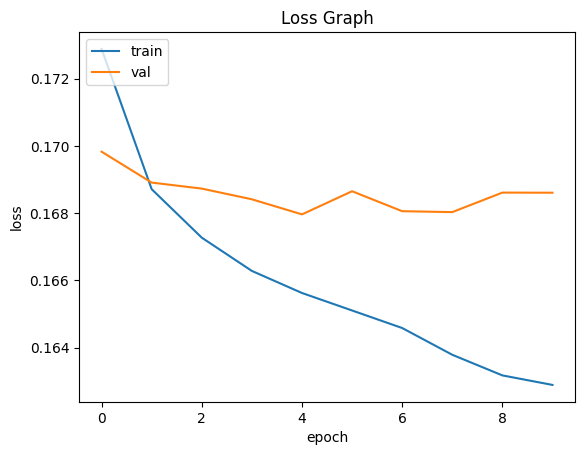

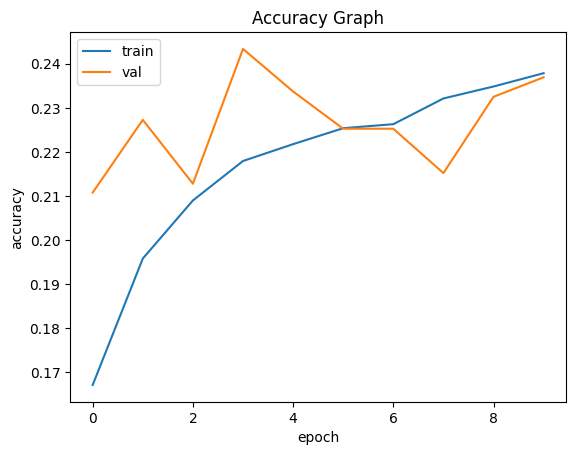

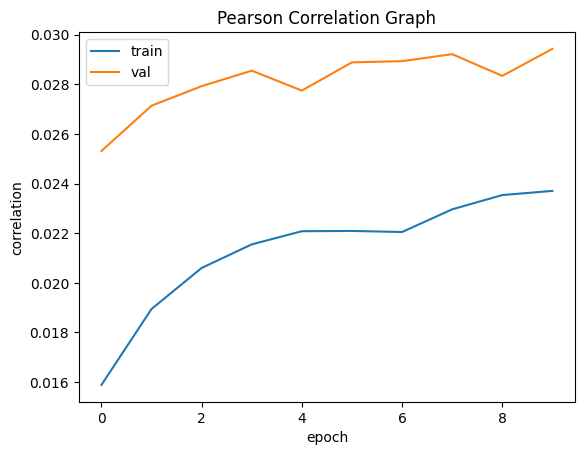

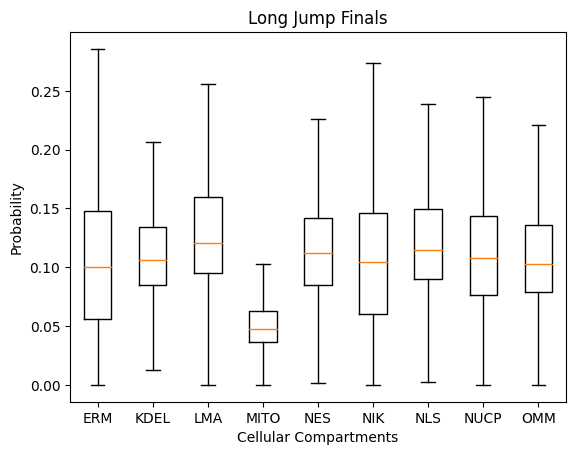

In [12]:
plt_data = [history.history['loss'], history.history['val_loss']]
plot_line_graph(plt_data, "Loss Graph", 'loss', 'epoch', ['train', 'val'])

plt_data = [history.history['accuracy'], history.history['val_accuracy']]
plot_line_graph(plt_data, "Accuracy Graph", 'accuracy', 'epoch', ['train', 'val'])

plt_data = [history.history['tf_pearson'], history.history['val_tf_pearson']]
plot_line_graph(plt_data, "Pearson Correlation Graph", 'correlation', 'epoch', ['train', 'val'])

box_plot(train_data)

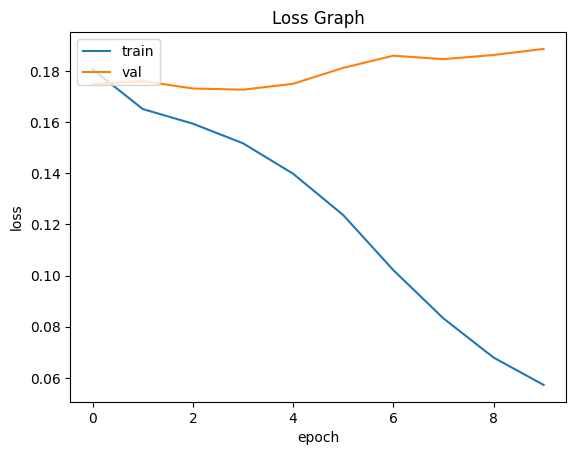

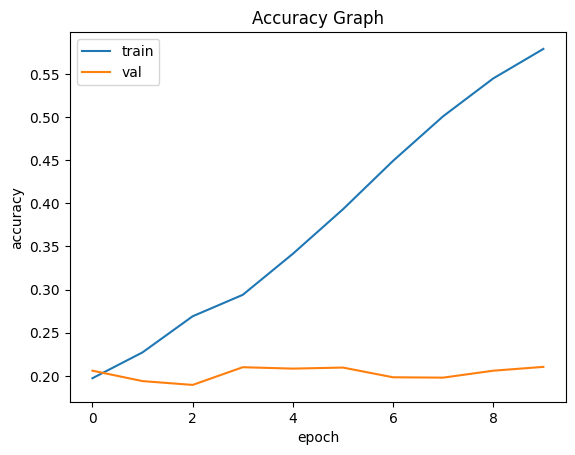

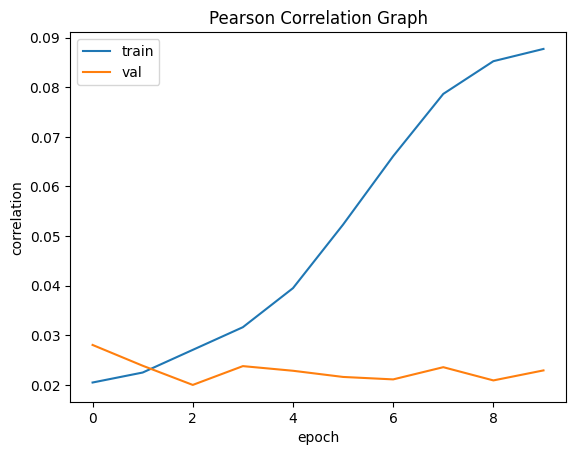

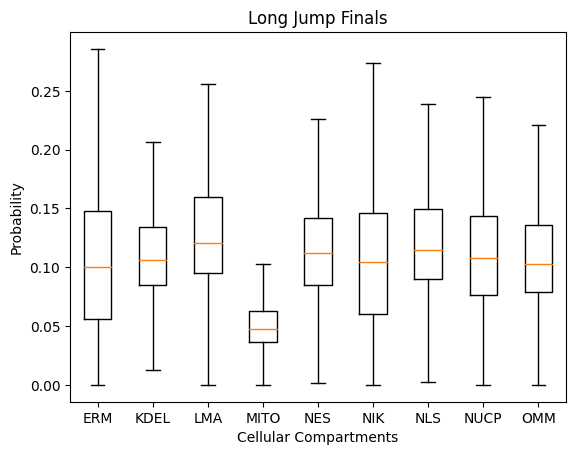

In [6]:
plt_data = [history.history['loss'], history.history['val_loss']]
plot_line_graph(plt_data, "Loss Graph", 'loss', 'epoch', ['train', 'val'])

plt_data = [history.history['accuracy'], history.history['val_accuracy']]
plot_line_graph(plt_data, "Accuracy Graph", 'accuracy', 'epoch', ['train', 'val'])

plt_data = [history.history['tf_pearson'], history.history['val_tf_pearson']]
plot_line_graph(plt_data, "Pearson Correlation Graph", 'correlation', 'epoch', ['train', 'val'])

box_plot(train_data)

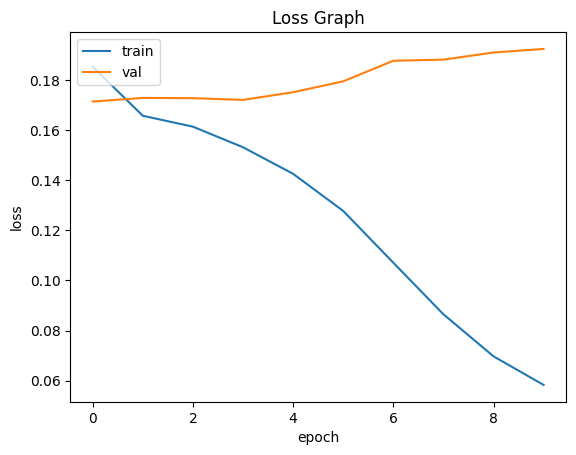

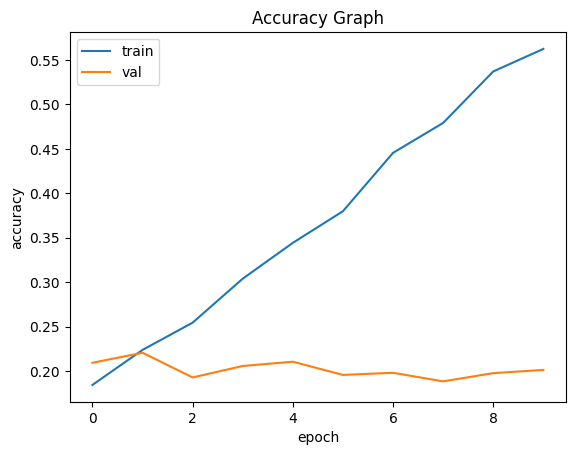

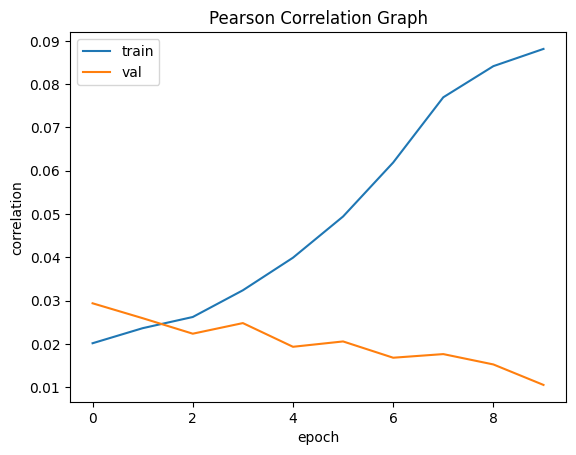

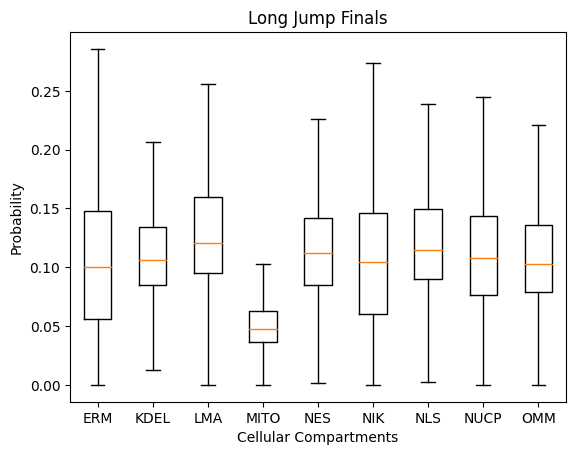

In [20]:
plt_data = [history.history['loss'], history.history['val_loss']]
plot_line_graph(plt_data, "Loss Graph", 'loss', 'epoch', ['train', 'val'])

plt_data = [history.history['accuracy'], history.history['val_accuracy']]
plot_line_graph(plt_data, "Accuracy Graph", 'accuracy', 'epoch', ['train', 'val'])

plt_data = [history.history['tf_pearson'], history.history['val_tf_pearson']]
plot_line_graph(plt_data, "Pearson Correlation Graph", 'correlation', 'epoch', ['train', 'val'])

box_plot(train_data)

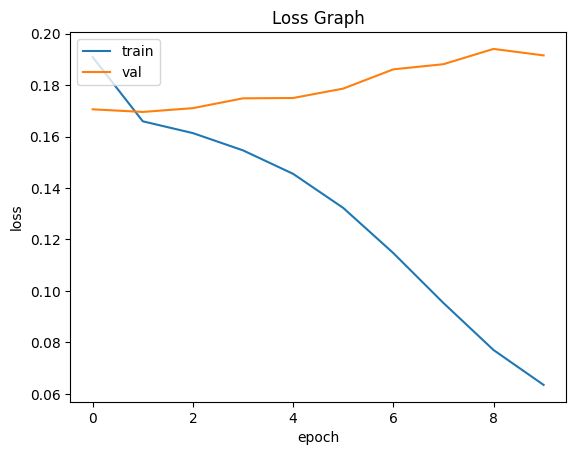

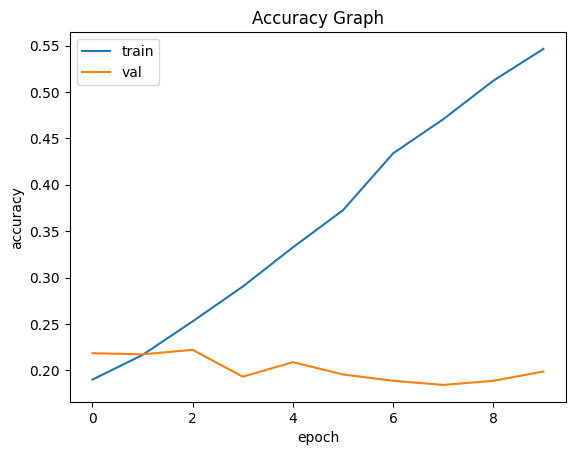

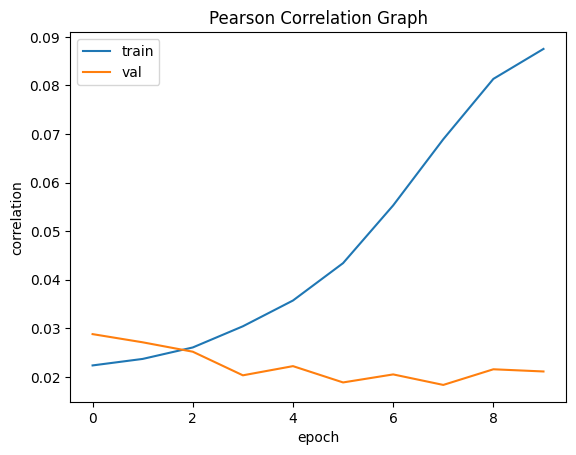

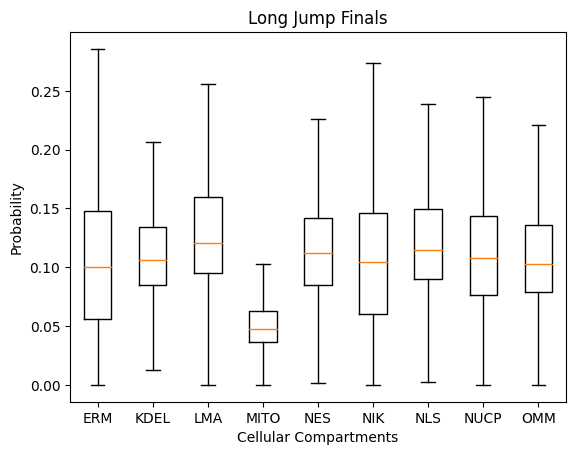

In [13]:
plt_data = [history.history['loss'], history.history['val_loss']]
plot_line_graph(plt_data, "Loss Graph", 'loss', 'epoch', ['train', 'val'])

plt_data = [history.history['accuracy'], history.history['val_accuracy']]
plot_line_graph(plt_data, "Accuracy Graph", 'accuracy', 'epoch', ['train', 'val'])

plt_data = [history.history['tf_pearson'], history.history['val_tf_pearson']]
plot_line_graph(plt_data, "Pearson Correlation Graph", 'correlation', 'epoch', ['train', 'val'])

box_plot(train_data)

In [ ]:
test_result = model.evaluate(test_data, **param_dataLoader_valid)
result = dict(zip(model.model.metrics_names, test_result))
TEST_ACCURACY = result['accuracy']
TEST_LOSS = result['loss']

In [ ]:
VALIDATION_ACCURACY

In [ ]:
VALIDATION_LOSS